In [1]:
#import geopandas
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os, os.path
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from ipynb.fs.full.interp_data import interpolate_scenario_data

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style("ticks")

In [4]:
C1_c = "#649B1C"
C2_c = "#00B593"
C3_c = "#4E84D4"

- assume natural gas Emission factor from MESSAGE Doc https://docs.messageix.org/projects/global/en/stable/emissions/message/index.html
    - Emission factor [tCO2/TJ] 56.1

In [5]:
ems_fac = 56.1 # tCO2/TJ

In [6]:
crosswalk = pd.read_excel("../../data/MESSAGE/mapping_file_R10edit.xlsx",sheet_name="main")
AR6_list = crosswalk["AR6_R10"].unique()
crosswalk.head()

,Countries,R10,AR6_R10,GEM_Name,ISO
0,Algeria,Africa (R10),R10AFRICA,Algeria,DZA
1,Angola,Africa (R10),R10AFRICA,Angola,AGO
2,Benin,Africa (R10),R10AFRICA,NaN,BEN
3,Botswana,Africa (R10),R10AFRICA,NaN,BWA
4,Burkina Faso,Africa (R10),R10AFRICA,NaN,BFA


In [7]:
# load data
ar6_world = pd.read_csv("../../data/AR6_data/1668008174375-AR6_Scenarios_Database_R10_regions_v1.1.csv/AR6_Scenarios_Database_R10_regions_v1.1.csv")
ar6_scen = pd.read_excel("../../data/AR6_data/AR6_Scenarios_Database_World_v1.1/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx",sheet_name = "meta_Ch3vetted_withclimate")

In [8]:
ar6_scen_123 = ar6_scen[ar6_scen["Category"].isin(["C1","C2","C3"])]

In [9]:
# unit in EJ
# EJ/yr x 10^6 TJ/EJ x tCO2/TJ x 1MtCO2/10^6 tCO2
ar6_gas_gen = ar6_world.query("Variable=='Primary Energy|Gas|Electricity|w/o CCS'")#Capacity|Electricity|Coal|w/o CCS
ar6_gas_gen = interpolate_scenario_data(ar6_gas_gen)
ar6_gas_gen = pd.merge(ar6_gas_gen,ar6_scen_123[["Model","Scenario","Category"]],
                                  left_on=["Model","Scenario"],right_on=["Model","Scenario"])
ar6_world_gas_melt = pd.melt(ar6_gas_gen,id_vars=["Model","Scenario","Category","Region"],value_vars=ar6_gas_gen.columns[5:-1],
                             var_name="Year",value_name="GasGen_EJ/yr").dropna()
ar6_world_gas_melt["Year"] = ar6_world_gas_melt["Year"].astype(int)
ar6_world_gas_melt = ar6_world_gas_melt.sort_values("Category")
ar6_world_gas_melt = ar6_world_gas_melt[ar6_world_gas_melt["Year"]>=2020]
ar6_world_gas_melt["MtCO2/yr"] = ar6_world_gas_melt["GasGen_EJ/yr"] *ems_fac
ar6_world_gas_melt

,Model,Scenario,Category,Region,Year,GasGen_EJ/yr,MtCO2/yr
136766,IMAGE 3.2,SSP2_SPA1_19I_D_LB,C1,R10EUROPE,2039,0.306825,17.212903
134524,MESSAGEix-GLOBIOM_1.1,EN_NPi2020_600_DR4p,C1,R10PAC_OECD,2038,0.128079,7.185205
134525,MESSAGEix-GLOBIOM_1.1,EN_NPi2020_600_DR4p,C1,R10REF_ECON,2038,0.084572,4.744473
134526,MESSAGEix-GLOBIOM_1.1,EN_NPi2020_600_DR4p,C1,R10REST_ASIA,2038,0.752214,42.199179
158838,REMIND-MAgPIE 2.1-4.2,EN_NPi2020_500,C1,R10REST_ASIA,2048,0.144680,8.116548
...,...,...,...,...,...,...,...
69940,IMAGE 3.0,CO_2Deg2020,C3,R10LATIN_AM,2065,1.853669,103.990819
69939,IMAGE 3.0,CO_2Deg2020,C3,R10EUROPE,2065,0.130681,7.331192
69938,IMAGE 3.0,CO_2Deg2020,C3,R10CHINA+,2065,1.843335,103.411073
69937,GEM-E3_V2021,EN_NPi2020_800f,C3,R10ROWO,2065,0.697216,39.113844


### gas fleet data
- assume baseline capacity factor 35% from the Davis analysis
- the over aged plants are assumed to decline linearly in the next 5 year (Tong et al. 2019 did it randomly)

In [10]:
cap_fac = 0.35
heat_rate = 8000

In [11]:
hist_gas = pd.read_csv("../../data/global_GEM/analysis_plant/gas_plant_annual_summary.csv")
hist_gas_sum = pd.merge(hist_gas,crosswalk[["GEM_Name","AR6_R10"]],left_on="Country",right_on="GEM_Name")
hist_gas_sum = hist_gas_sum.groupby(["Year","AR6_R10"]).sum()[["Capacity elec. (MW)"]]
hist_gas_sum["GW"] = hist_gas_sum["Capacity elec. (MW)"]/1000
hist_gas_sum = hist_gas_sum[["GW"]]
hist_gas_sum["Type"] = "Historical"
hist_gas_sum = hist_gas_sum.reset_index()
#hist_gas_sum = hist_gas_sum[hist_gas_sum["Year"]>=2020]
hist_gas_sum["MWh/yr"] = hist_gas_sum["GW"]*24*365*cap_fac*1000
hist_gas_sum["MtCO2/yr"] = hist_gas_sum["MWh/yr"]*659/(10**9)
hist_gas_sum = hist_gas_sum.set_index(["Year","AR6_R10"])
hist_gas_sum.to_csv("gas_historical.csv")
hist_gas_sum.tail()

GW        Type        MWh/yr     MtCO2/yr
Year AR6_R10                                                       
2023 R10MIDDLE_EAST  281.996  Historical  8.645997e+08   569.771226
     R10NORTH_AM     567.794  Historical  1.740856e+09  1147.224370
     R10PAC_OECD     101.921  Historical  3.124898e+08   205.930769
     R10REF_ECON     157.885  Historical  4.840754e+08   319.005695
     R10REST_ASIA    165.453  Historical  5.072789e+08   334.296794

In [12]:
aged_gas_data = pd.read_csv("../../data/global_GEM/analysis_plant/gas_plant_geriatric.csv")
aged_gas_sum = pd.merge(aged_gas_data,crosswalk[["GEM_Name","AR6_R10"]],left_on="Country",right_on="GEM_Name")
aged_gas_sum = aged_gas_sum.groupby(["Year","AR6_R10"]).sum()[["GW"]]
aged_gas_sum

GW
Year AR6_R10               
2023 R10AFRICA        2.833
     R10EUROPE       13.686
     R10INDIA+        0.674
     R10LATIN_AM     11.162
     R10MIDDLE_EAST  19.404
     R10NORTH_AM     81.166
     R10PAC_OECD     11.891
     R10REF_ECON     68.975
     R10REST_ASIA     1.478

In [66]:
# MWh/yr x ems factor tCO2/TJ x (8000 Btu/KWh) x (1000 KWh/MWh)x (1.055TJ/Btu) x (1MtCO2/10^6 tCO2)
# linearly retired super old units in the next 5 years 
prev_dataset = hist_gas_sum.loc[[2023],:]
prev_dataset["MWh/yr"] = prev_dataset["GW"]*24*365*cap_fac*1000
prev_dataset["MtCO2/yr"] = prev_dataset["MWh/yr"]*659/(10**9)
for current_type in ["low","mid","high"]:
    com_gas = pd.read_csv("../../data/global_GEM/analysis_plant/gas_plant_current_committed_"+current_type+".csv")
    com_gas_sum = pd.merge(com_gas,crosswalk[["GEM_Name","AR6_R10"]],left_on="Country",right_on="GEM_Name")
    com_gas_sum = com_gas_sum.groupby(["Year","AR6_R10"]).sum()[["GW"]]
    com_gas_sum = com_gas_sum.reset_index().set_index("AR6_R10")
    for n_yr in np.arange(4):
        com_gas_sum_yr = com_gas_sum[com_gas_sum["Year"]==(n_yr+2024)]
        aged_gas_sum = aged_gas_sum.reset_index().set_index("AR6_R10")
        com_gas_sum_yr["aged"] = aged_gas_sum["GW"]*(4-n_yr)/5
        com_gas_sum_yr = com_gas_sum_yr.fillna(0)
        com_gas_sum_yr["GW_new"] = com_gas_sum_yr["GW"]+com_gas_sum_yr["aged"]
        com_gas_sum_yr = com_gas_sum_yr.reset_index().set_index(["Year","AR6_R10"])
        com_gas_sum_yr["MWh/yr"] = com_gas_sum_yr["GW_new"]*24*365*cap_fac*1000
        com_gas_sum_yr["MtCO2/yr"] = com_gas_sum_yr["MWh/yr"]*659/(10**9)
        if n_yr == 0:
            aged_gas = pd.concat([com_gas_sum_yr,prev_dataset])
        else:
            aged_gas = pd.concat([aged_gas,com_gas_sum_yr])
    aged_gas["Type"] = "Current_" + current_type
    
    new_gas_sum = com_gas_sum[com_gas_sum["Year"]>2027]
    new_gas_sum = new_gas_sum.reset_index().set_index(["Year","AR6_R10"])
    new_gas_sum["aged"] = aged_gas_sum["GW"]
    new_gas_sum = new_gas_sum.fillna(0)
    new_gas_sum["GW"] = new_gas_sum["GW"]-new_gas_sum["aged"]
    #new_gas_sum = pd.concat([new_gas_sum,aged_gas.loc[[2027],:][["GW"]]])
    new_gas_sum["Type"] = "Current_"+current_type
    if current_type =="low":
        sum_com_gas_all = new_gas_sum
        aged_gas_all = aged_gas
    else:
        sum_com_gas_all = pd.concat([sum_com_gas_all,new_gas_sum])
        aged_gas_all = pd.concat([aged_gas_all,aged_gas])
#sum_com_gas_all["MtCO2/yr"] = sum_com_gas_all["MWh/yr"]*heat_rate*101.2*1.05506/(10**6)/(10**6) ## double check this
sum_com_gas_all["MWh/yr"] = sum_com_gas_all["GW"]*24*365*cap_fac*1000
sum_com_gas_all["MtCO2/yr"] = sum_com_gas_all["MWh/yr"]*659/(10**9)
#sum_com_gas_all = sum_com_gas_all.drop(columns="Year")
aged_gas_all.to_csv("gas_aged.csv")
sum_com_gas_all.to_csv("gas_future.csv")
sum_com_gas_all = pd.concat([sum_com_gas_all,aged_gas_all.loc[[2027]]])
sum_com_gas_all

GW     aged          Type        MWh/yr  \
Year AR6_R10                                                        
2028 R10AFRICA        92.515   0.0000   Current_low  2.836510e+08   
     R10CHINA+       120.101   0.0000   Current_low  3.682297e+08   
     R10EUROPE       175.058   0.0000   Current_low  5.367278e+08   
     R10INDIA+        39.915   0.0000   Current_low  1.223794e+08   
     R10LATIN_AM      94.791   0.0000   Current_low  2.906292e+08   
...                      ...      ...           ...           ...   
2027 R10MIDDLE_EAST  262.188   3.8808  Current_high  8.157669e+08   
     R10NORTH_AM     480.724  16.2332  Current_high  1.523671e+09   
     R10PAC_OECD      83.692   2.3782  Current_high  2.638912e+08   
     R10REF_ECON      87.072  13.7950  Current_high  3.092582e+08   
     R10REST_ASIA    161.955   0.2956  Current_high  4.974603e+08   

                        MtCO2/yr    GW_new  
Year AR6_R10                                
2028 R10AFRICA        186.926002       NaN  
     R10CHINA+        242.663350       NaN  
     R10EUROPE        353.703639       NaN  
     R10INDIA+         80.648018       NaN  
     R10LATIN_AM      191.524647       NaN  
...                          ...       ...  
2027 R10MIDDLE_EAST   537.590414  266.0688  
     R10NORTH_AM     1004.099041  496.9572  
     R10PAC_OECD      173.904323   86.0702  
     R10REF_ECON      203.801168  100.8670  
     R10REST_ASIA     327.826364  162.2506  

[1410 rows x 6 columns]

In [61]:
base_data = pd.concat([aged_gas_all,sum_com_gas_all])
for lt in ["low","mid","high"]:
    gas_const = pd.read_csv("../../data/global_GEM/analysis_plant/gas_plant_construction_"+lt+".csv")
    gas_const_sum = pd.merge(gas_const,crosswalk[["GEM_Name","AR6_R10"]],left_on="Country",right_on="GEM_Name")
    gas_const_sum = gas_const_sum.groupby(["Year","AR6_R10"]).sum()[["GW"]]
    gas_const_sum["MWh/yr"] = gas_const_sum["GW"]*24*365*cap_fac*1000
    gas_const_sum["MtCO2/yr"] = gas_const_sum["MWh/yr"]*659/(10**9)
    this_base = base_data[base_data["Type"]=="Current_"+lt]
    this_base = this_base.reset_index()
    gas_const_sum_added = pd.concat([gas_const_sum.copy().reset_index(),this_base])
    gas_const_sum_added = gas_const_sum_added.groupby(["Year","AR6_R10"]).sum()[["GW","MWh/yr","MtCO2/yr"]]
    gas_const_sum_added["Type"] = "Const_"+lt
    if lt == "low":
        gas_const_all = gas_const_sum_added
    else:
        gas_const_all = pd.concat([gas_const_all,gas_const_sum_added])
gas_const_all.to_csv("gas_construction.csv")
gas_const_all

GW       MWh/yr    MtCO2/yr        Type
Year AR6_R10                                                      
2023 R10AFRICA       112.3770  344547882.0  227.057054   Const_low
     R10CHINA+       121.7250  373208850.0  245.944632   Const_low
     R10EUROPE       226.9490  695825634.0  458.549093   Const_low
     R10INDIA+        56.0500  171849300.0  113.248689   Const_low
     R10LATIN_AM     116.0360  355766376.0  234.450042   Const_low
...                       ...          ...         ...         ...
2076 R10MIDDLE_EAST   15.4429   47347931.4   31.202287  Const_high
     R10NORTH_AM       0.1610     493626.0    0.325300  Const_high
     R10PAC_OECD       0.0000          0.0    0.000000  Const_high
     R10REF_ECON       0.0000          0.0    0.000000  Const_high
     R10REST_ASIA      1.0500    3219300.0    2.121519  Const_high

[1560 rows x 4 columns]

In [14]:
heat_rate*101.2*1.05506/(10**6)/(10**6)

8.541765760000001e-07

In [15]:
659/(10**9)

6.59e-07

### plot

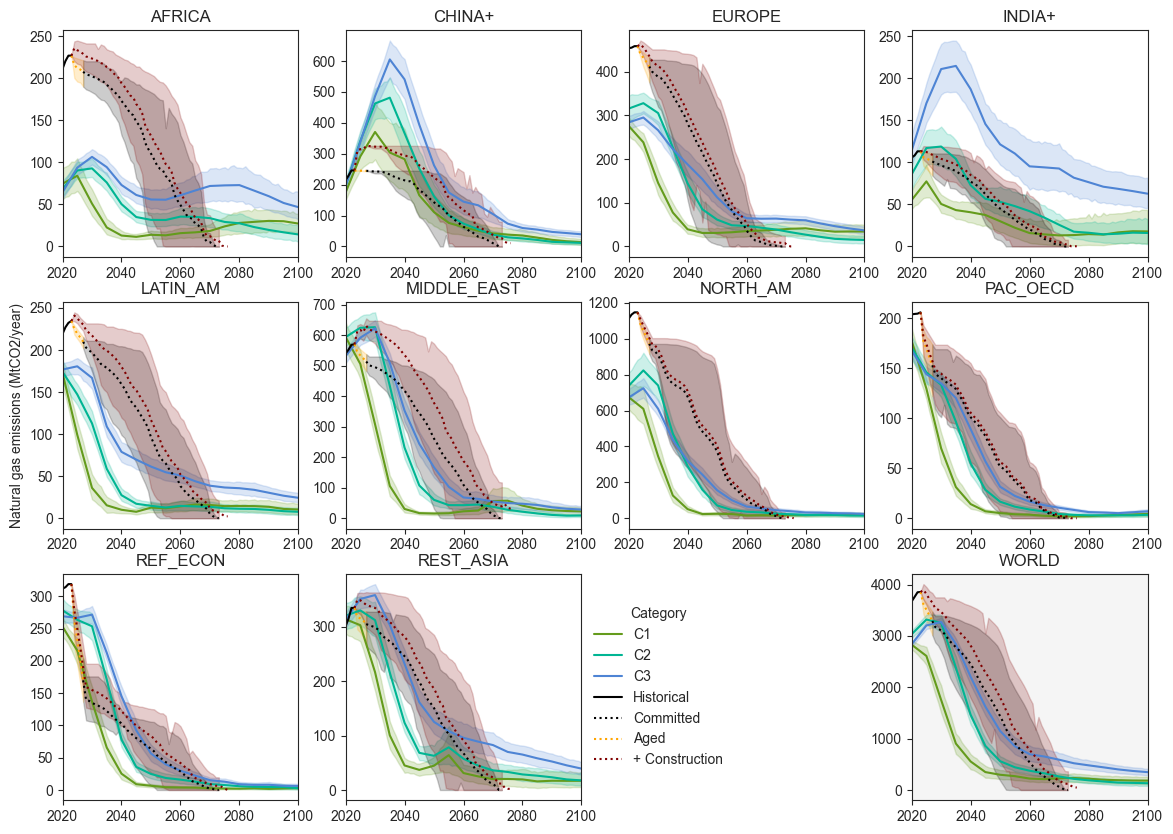

In [68]:
fig, axes = plt.subplots(3,4,figsize=(14,10))
row_list = [0,0,0,0,1,1,1,1,2,2,2]
col_list = [0,1,2,3,0,1,2,3,0,1,3]
plot_type = "hist" # "hist" "2050"

sum_com_gas_all_p = sum_com_gas_all.reset_index()
aged_gas_p = aged_gas_all.reset_index()
hist_gas_sum_p = hist_gas_sum.reset_index()
gas_const_all_p = gas_const_all.reset_index()

for n_r10 in np.arange(len(AR6_list)+1):
    this_ax = axes[row_list[n_r10],col_list[n_r10]]
    
    if n_r10<10: # separate R10 regions
        r10 = AR6_list[n_r10]
        ar6_world_gas_r = ar6_world_gas_melt[ar6_world_gas_melt["Region"]==r10]
        historical_gas = hist_gas_sum_p[hist_gas_sum_p["AR6_R10"]==r10]
        committed_gas = sum_com_gas_all_p[sum_com_gas_all_p["AR6_R10"]==r10]
        old_gas = aged_gas_p[aged_gas_p["AR6_R10"]==r10]
        construction_gas = gas_const_all_p[gas_const_all_p["AR6_R10"]==r10]
    else: # summarize data in the wolrd
        r10 = "R10WORLD"
        ar6_world_gas_r = ar6_world_gas_melt.groupby(["Year","Model","Scenario","Category"]).sum()[["MtCO2/yr"]]
        ar6_world_gas_r = ar6_world_gas_r.sort_values("Category")
        historical_gas = hist_gas_sum_p.groupby(["Year","Type"]).sum()[["MtCO2/yr"]]
        committed_gas = sum_com_gas_all_p.groupby(["Year","Type"]).sum()[["MtCO2/yr"]]
        old_gas = aged_gas_p.groupby(["Year","Type"]).sum()[["MtCO2/yr"]]
        construction_gas = gas_const_all_p.groupby(["Year","Type"]).sum()[["MtCO2/yr"]]

    #this_ax.vlines(x = 2023, ymin = committed_gas.query("Year==2023")["GW"],
    #               ymax = historical_gas.query("Year==2023")["GW"], color="orange",linestyle=":",label="Over aged")
    sns.lineplot(x='Year', y='MtCO2/yr', hue='Category', data=ar6_world_gas_r,palette=[C1_c,C2_c,C3_c],ax=this_ax)
    sns.lineplot(x='Year', y='MtCO2/yr', data=historical_gas,ax=this_ax,color="black",label="Historical")
    sns.lineplot(x='Year', y='MtCO2/yr', data=committed_gas,ax=this_ax,color="black",label="Committed",linestyle=":")
    sns.lineplot(x='Year', y='MtCO2/yr', data=old_gas,ax=this_ax,color="orange",label="Aged",linestyle=":")
    sns.lineplot(x='Year', y='MtCO2/yr', data=construction_gas,ax=this_ax,color="maroon",label="+ Construction",linestyle=":")
    
    this_ax.set_xlabel(None)
    this_ax.set_title(r10[3:])
    if n_r10 == 9:
        this_ax.legend(title = 'Category', loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
    else:
        this_ax.get_legend().remove()
        
    if n_r10 == 4 :
        this_ax.set_ylabel("Natural gas emissions (MtCO2/year)")
    else:
        this_ax.set_ylabel(None)
    
    if n_r10 == 10:
        this_ax.set_facecolor('whitesmoke')
        
    if plot_type == "hist":
        this_ax.set_xlim([2020,2100])
    elif plot_type == "2050":
        this_ax.set_xlim([2020,2050])
    
fig.delaxes(axes[2,2])
fig.savefig("committed_gas_ems_"+plot_type+"_R10.png",dpi=600, bbox_inches='tight')